## Import libraries

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
%matplotlib inline

## Import utilities

In [112]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)



def smooth(loss, cur_loss):
    return loss * 0.999 + cur_loss * 0.001



def print_sample(sample_ix, ix_to_char):
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    txt = txt[0].upper() + txt[1:]  # capitalize first character 
    print ('%s' % (txt, ), end='')


def get_initial_loss(vocab_size, seq_length):
    return -np.log(1.0/vocab_size)*seq_length


def initialize_parameters(hidden_size, vocab_size):
    
    Wax = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
    Waa = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
    Wya = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
    b = np.zeros((hidden_size, 1)) # hidden bias
    by = np.zeros((vocab_size, 1)) # output bias
    
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b,"by": by}
    
    return parameters

def update_parameters_lronly(parameters, gradients, lr):

    parameters['Wax'] -= lr * gradients['dWax']
    parameters['Waa'] -= lr * gradients['dWaa']
    parameters['Wya'] -= lr * gradients['dWya']
    parameters['b']  -= lr * gradients['db']
    parameters['by']  -= lr * gradients['dby']
    
    return parameters


def sample(parameters, char_to_ix, seed):
    
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    x = np.zeros((vocab_size,1))
    a_prev = np.zeros((n_a,1))
    
    indices = []
    idx = -1 
    
    newline_character = char_to_ix['\n']
    
    while idx != newline_character:
        a = np.tanh(np.dot(Wax,x)+np.dot(Waa,a_prev)+b)
        z = np.dot(Wya,a)+by
        y = softmax(z)
        p = y
        idx = np.random.choice(list(range(y.size)), p = p.ravel())
        indices.append(idx)
        
        x = np.zeros((vocab_size,1))
        x[idx] = 1
        
        a_prev = a
    
    return indices

def chunks(l, n):
    for i in range(0, len(l), n): yield l[i:i + n]


def clip(gradients, maxValue):
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
    for gradient in [dWax, dWaa, dWya, db, dby]:
        np.clip(gradient, -maxValue, maxValue, out=gradient)
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

def normalize(v):
    norm=np.linalg.norm(v, ord=1)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm




## Datasource

#### returns input-output object to be taken to batcher  

In [113]:
class CharDatasource:
    
    def __init__(self, path, seq_len, *args):
        
        """Initialize vocabularies for char rnn (w||w/o lstm). 
        In our case we want to train only characters and < (end of word) token
         Cleaning data with regex: \n character left to indicate end of token(word) 
        to train  ending word, cleaning all symbols and spaces
        """
        
        data = open(path, 'r').read().lower()
        data = re.sub('[^0-9a-zA-Z\n]+', '', data)
        chars = list(set(data))
        
        self._seq_len = seq_len
        self._char2ix = { ch:i for i,ch in enumerate(sorted(chars)) }
        self._ix2char = { i:ch for i,ch in enumerate(sorted(chars)) }
        self._vocab_size = len(self._char2ix)
        
        """Initialize vocabulary with char appearance statistics. 
        It can be useful to determine unfrequently used characters to omit them in training. 
        In this experiment however we are not excluding characters due to small dataset.  
        """
        
        self._char_stats = {char:0 for char in sorted(chars)}
        
        # Initialize x, y sets as empty lists
        
        self._tokens = []
        self._targets = []
        
        """generator function for getting dataset  desired sequence length. We are not setting 
        sequence length to the length of token to apply vectorization without padding.
        This is a utility function which is not supposed to be inside of the object
        """
        
        def chunks(l, n):
            for i in range(0, len(l), n): yield l[i:i + n]
                
        
        
        
        
        """Call generator to encode input and output sequences. 
        Output is a one-step forward sequence in the same datasource - 
        We want our model to learn predicting next character
        """
        
        source = chunks(data, seq_len)
        
        while True:
            try:
                s = next(source)
                for ch in s:
                    self._char_stats[ch]+=1
                self._tokens.append([self._char2ix['\n']]+[self._char2ix[ch] for ch in s])
                self._targets.append([self._char2ix[ch] for ch in s]+[self._char2ix['\n']])
        
            except StopIteration:
                break
        
        """Vectorize with numpy and quickly one-hot the input set.
        Final shapes = tokens - (num_of_sequences, sequence length, vocab_size)
        targets - (num_of_sequences, sequence length, char2idx[character])
        We are not creating one-hot for outputs because we want to count loss 
        between only most-probable character index and target
        """
        
        self._tokens = np.array(self._tokens[:-1], dtype=np.int32)
        self._targets = np.array(self._targets[:-1])
        x_values = np.max(self._tokens)+1
        self._tokens = np.eye(x_values)[self._tokens]
    
    # TO-DO: @properties

    def __getitem__(self, idx):
        return self._tokens[idx], self._targets[idx]
    
    def __len__(self):
        return len(self._tokens)
    

## Model

#### Neural net architecture for raw RNN - to be called once per epoch. Returns gradients and last hidden state from sequence to iterate through batches

In [114]:
class CharModelRNN:
    
    def __init__(self, clip_ratio, params):
        
        """ Initialize necessary hyperparams and nn layers. Import updated params 
        (or zero params).
        Reset all grads 
        """
        
        self._clip_ratio = clip_ratio
        self._Wax = params['Wax']
        self._Waa = params['Waa']
        self._Wya = params['Wya']
        self._b = params['b']
        self._by = params['by']
        
        
    def forward_rnn(self, X, Y, hidden_back):
        
        hidden, output = {}, {}
        
        hidden[-1]= hidden_back
        loss = 0
        
        for t in range(seq_len):
            hidden[t] = np.tanh(np.dot(self._Wax, X[:,t].T)+ 
                                np.dot(self._Waa, hidden[t-1])+ self._b)
            preoutput = np.dot(self._Wya, hidden[t]) + self._by
            output[t] = np.exp(preoutput) / np.sum(np.exp(preoutput))
            
            loss-= np.sum(np.log(output[t].T[range(len(X)),Y[:,t]])) / len(X)
            
        cache = (output, hidden)   
       
        return loss, cache
    
    def rnn_backward(self, X, Y, cache):
    
        gradients = {}
        output, hidden = cache
        gradients['dWax'] = np.zeros_like(self._Wax) 
        gradients['dWaa'] = np.zeros_like(self._Waa)
        gradients['dWya'] = np.zeros_like(self._Wya)
        gradients['db'] = np.zeros_like(self._b)
        gradients['dby'] = np.zeros_like(self._by)
        gradients['da_next'] = np.zeros_like(hidden[0])

        for t in reversed(range(seq_len)):
            dy = np.copy(output[t])
            dy[Y[:,t]] -= 1
            gradients['dWya'] += np.dot(dy, hidden[t].T)
            gradients['dby'] += np.sum(dy, axis=1).reshape(-1,1)
            da = np.dot(self._Wya.T, dy) + gradients['da_next']

            daraw = (1 - hidden[t] * hidden[t] ) * da
            gradients['db'] += np.sum(daraw, axis=1).reshape(-1,1)
            gradients['dWax'] += np.dot(daraw, X[:,t])#.reshape(1,-1))
            gradients['dWaa'] += np.dot(daraw, hidden[t-1].T)
            gradients['da_next'] = np.dot(self._Waa.T, daraw)

        return gradients, hidden[t-1]
        
    def optimize(self, X, Y, hidden_back):

        loss, cache = self.forward_rnn(X, Y, hidden_back)
        gradients, hidden_back = self.rnn_backward(X, Y, cache)
        gradients = clip(gradients, self._clip_ratio)
        return loss, gradients, hidden_back
        
        
            

## Dataloader/Batcher
#### Generate input/output batches from datasource for train/test modes

In [115]:
class RNNDataLoader(CharDatasource):
    
    def __init__(self, batch_size, **kwargs):
        
        """ CharDatasource is used as parent object.
        train/test mode defines which part of dataset to use for batching
        """
        
        self._batch_size = batch_size
        super().__init__(**kwargs)
        
        """Just to indicate - we are encountering chunks utility function for the second time.
        In project this should go to utility - otherwise it's a bad practice
        """
        
        """Splitting dataset into train/test
        """
        
        train_set = (self._tokens, self._targets)
        
        """Eventhough we are having pretty small dataset, it's a 
        good practice to use generators instead of keeping
        additional data arrays to free up memory
        """
        
        x_loader = chunks(train_set[0], self._batch_size)
        y_loader = chunks(train_set[1], self._batch_size)

            
        self._batches=[]
        
        while True:
            try:
                x, y = next(x_loader), next(y_loader)
                if len(x)==self._batch_size:
                    self._batches.append((x,y))

            except StopIteration:
                break
        
        
    def _getbatch(self, idx):
        return self._batches[idx]

## Trainer

#### Trainer brings together everything we created before, to iterate via epochs and update parameters of our model

In [147]:
class CharTrainer:
    
    def __init__(self, lr, n_epochs, hidden, vocab, batch_size, seq_len,
                 clip_ratio, path, **kwargs):
        self._lr = lr
        self._n_epochs = n_epochs
        self._hidden = hidden
        self._vocab = vocab
        self._batch_size = batch_size
        
        
        self._parameters = initialize_parameters(self._hidden, self._vocab)

        self._dataload = RNNDataLoader(batch_size=batch_size, 
                           path=path,  seq_len=seq_len)


        self._model = CharModelRNN(clip_ratio, self._parameters)

    def train(self):
        train_epoch_loss = {}
        
        batches = self._dataload._batches
        loss = get_initial_loss(self._vocab, self._batch_size)
        hidden_back = np.zeros((self._hidden, self._batch_size))
        
        for j in range(self._n_epochs):
        
            for index in range(len(batches)):
                
                X = batches[index][0]
                Y = batches[index][1]

                curr_loss, gradients, hidden_back = self._model.optimize(X, Y, 
                                                                         hidden_back)

                curr_loss = np.mean(curr_loss)
                loss = smooth(loss, curr_loss)
                train_epoch_loss.update({j:loss})
                
                self._parameters = update_parameters_lronly(self._parameters, 
                                                     gradients, self._lr)

            if j % (self._n_epochs/10) == 0:

                print('Iteration: %d, Loss: %f' % (j, loss) + '\n')

                seed = 0
                """
                for name in range(5):
                    
                    sampled_indices = sample(self._parameters, 
                                             self._dataload._char2ix, seed)
                    print_sample(sampled_indices, self._dataload._ix2char)
                """ 
        plt.plot(train_epoch_loss.values())
        f = open("params_char_lmodel_fairycountry.pkl","wb")
        pickle.dump(self._parameters,f)
        f.close()
        return self._parameters

## Lab

#### Probing data with custom hyperparams

In [181]:
n_epochs = 500
hidden = 10
vocab = 27
batch_size = 1
seq_len = 15
path = 'test.txt'
clip_ratio = 5
lr = 0.003

trainer = CharTrainer(lr=lr, clip_ratio=clip_ratio,
                     path=path, seq_len=seq_len,
                     batch_size=batch_size, 
                     vocab = vocab, 
                     hidden=hidden, n_epochs = n_epochs)


Iteration: 0, Loss: 10.388622

Iteration: 50, Loss: 37.806180

Iteration: 100, Loss: 35.572734

Iteration: 150, Loss: 34.674363

Iteration: 200, Loss: 34.209972

Iteration: 250, Loss: 33.940058

Iteration: 300, Loss: 33.876025

Iteration: 350, Loss: 33.633727

Iteration: 400, Loss: 33.511995

Iteration: 450, Loss: 33.407437



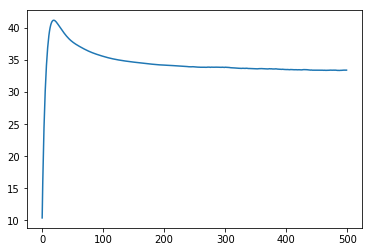

In [182]:
parameters = trainer.train()

## Inference 

### Testing model on new samples

In [263]:
datas = CharDatasource('test.txt', 15)

with open('params_char_lmodel_fairycountry.pkl', 'rb') as f:
    params = pickle.load(f)
for i in range(20):
    sampled_indices = sample(params, datas._char2ix,0)
    print_sample(sampled_indices, datas._ix2char)

Ania
Egesovia

Ia
Othamorize

An
Iava
Alerdolai

Ha
E
Hbecoat
Iy
Icloussa
Itistan
Ia
Omonia
An
Ena
